## Improving Dataset
References
* https://github.com/aleju/imgaug
* http://blog.yhat.com/posts/image-processing-with-scikit-image.html
* http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html
* https://bradmontgomery.net/blog/pythons-zip-map-and-lambda/

In [1]:
import numpy as np
from driving_data import HandleData
import matplotlib.pyplot as plt
import os
import subprocess
import glob

import skimage
import skimage.filters
import skimage.color

In [2]:
# Load hdf5 file and get the whole training (batch=-1)
data = HandleData(shuffle = False)
xs, ys = data.LoadTrainBatch(-1,crop_up=190)
ys = np.array(ys)

Loading data
Number training images: 2352
Number validation images: 588


### Get histogram of inputs
Observe from the histogram that almost all the actions are angle=0 on the steering wheel, the problem is that if we backpropagate this the network will find fine output always angle=0

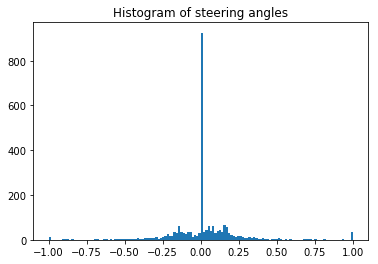

In [3]:
plt.hist(ys,bins='auto')
plt.title("Histogram of steering angles")
plt.show()

### Select images from dataset where steering angle is 0,Left,Right

In [4]:
# Create a list with images and angles
list_img_angles = list(zip(xs, ys))

# Select the items of the zip list where the angle is 0, left or right
list_img_angles_zeros = [(img,steering) for (img,steering) in list_img_angles if steering == 0]
list_img_angles_left = [(img,steering) for (img,steering) in list_img_angles if steering < 0]
list_img_angles_right = [(img,steering) for (img,steering) in list_img_angles if steering > 0]

# Display quantity
print('Number (angles==0)=%d'% len(list_img_angles_zeros))
print('Number (angles==Left)=%d'% len(list_img_angles_left))
print('Number (angles==Right)=%d'% len(list_img_angles_right))

Number (angles==0)=903
Number (angles==Left)=621
Number (angles==Right)=828


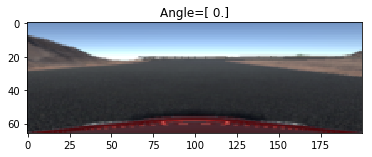

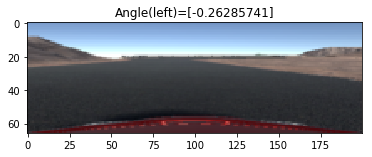

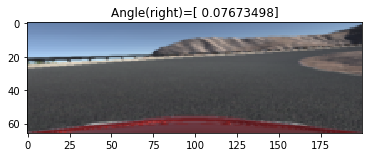

In [5]:
# Angle 0 example
[img,steering] = list_img_angles_zeros[0]
plt.imshow(img)
plt.title('Angle=' + str(steering))
plt.show()

# Angle (left) example
[img,steering] = list_img_angles_left[0]
plt.imshow(img)
plt.title('Angle(left)=' + str(steering))
plt.show()

# Angle (right) example
[img,steering] = list_img_angles_right[10]
plt.imshow(img)
plt.title('Angle(right)=' + str(steering))
plt.show()

## Define function to generate videos from matplotlib (depends on ffmpeg)

In [ ]:
def generate_video(list_img_angle):
    folder = os.getcwd()
    
    # Create folder if does not exist
    if not os.path.exists(folder + '/imgsVideo'):
        os.makedirs(folder + '/imgsVideo')
    
    cntFile = 0
    for img,angle in list_img_angle:
        plt.imshow(img)
        plt.title('Angle=' + str(angle))
        plt.savefig(folder + "/imgsVideo/file%02d.png" % cntFile)
        cntFile += 1

    os.chdir(folder + '/imgsVideo')
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    
    # Delete 
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    
    # Go back to previous directory
    os.chdir(folder)

# Generate videos for angle=0    
generate_video(list_img_angles_zeros)    

### Augmentation 1 (Flip left-right and inverse angle)

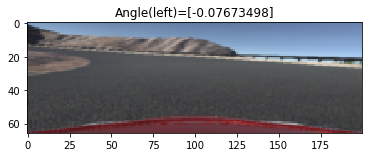

In [6]:
[img,steering] = list_img_angles_right[10]
plt.imshow(np.fliplr(img))
plt.title('Angle(left)=' + str(-steering))
plt.show()

### Augmentation 2 (Invert color)

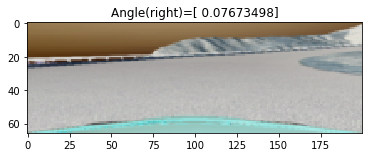

In [7]:
[img,steering] = list_img_angles_right[10]
plt.imshow(skimage.util.invert(img))
plt.title('Angle(right)=' + str(steering))
plt.show()

### Augmentation 3 (Add random noise)

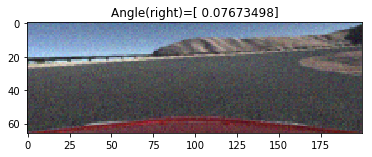

In [8]:
[img,steering] = list_img_angles_right[10]
plt.imshow(skimage.util.random_noise(img,var=0.001))
plt.title('Angle(right)=' + str(steering))
plt.show()

### Augmentation 4 (Add Gaussian blur)

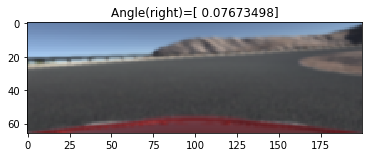

In [9]:
[img,steering] = list_img_angles_right[10]
plt.imshow(skimage.filters.gaussian(img,sigma=0.7, multichannel=True))
plt.title('Angle(right)=' + str(steering))
plt.show()

### Augmentation 5 (Convert to grayscale)

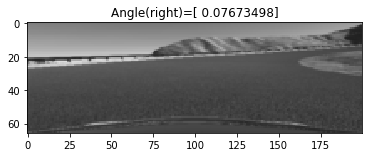

In [10]:
[img,steering] = list_img_angles_right[10]
r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
# To keep same number of channels add gray to each one.
img[:,:,0] = gray
img[:,:,1] = gray
img[:,:,2] = gray
plt.imshow(img)
plt.title('Angle(right)=' + str(steering))
plt.show()

## Balance dataset

In [34]:
# Shuffle data
data.shuffleData()

# Get zeros list
list_img_angles_zeros = [(img,steering) for (img,steering) in list_img_angles if steering == 0]
size_zeros = len(list_img_angles_zeros)

# Get list and number of samples that are not 0
list_img_angles_not_zeros = [(img,steering) for (img,steering) in list_img_angles if steering != 0]
size_not_zeros = len(list_img_angles_not_zeros)
print("Size not zeros: %d" % size_not_zeros)
print("Size zeros: %d" % size_zeros)

Size not zeros: 1449
Size zeros: 903


In [35]:
list_img_angles_balanced = list_img_angles_not_zeros
print(len(list_img_angles_balanced))
sub_zero = list_img_angles_zeros[0:150]
print(len(sub_zero))
list_img_angles_balanced.extend(sub_zero)
print(len(list_img_angles_balanced))

1449
150
1599


<class 'list'>


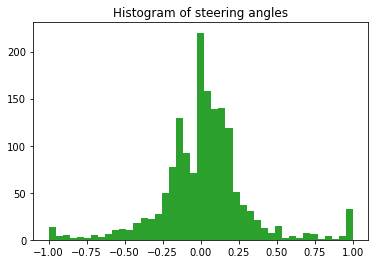

In [50]:
ys_balanced = []
for (tup_element) in list_img_angles_balanced:
    _,steer = tup_element
    ys_balanced.append(steer)


#ys_balanced = [(_,steer) for (tup_element) in list_img_angles_balanced]
print(type(ys_balanced))

plt.hist(np.array(ys_balanced),bins='auto')
plt.title("Histogram of steering angles")
plt.show()